In [58]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import csv

import nltk
from nltk.corpus import stopwords, wordnet
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity

import xgboost as xgb

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam

from datetime import datetime
import time 
import re

import string
import scipy.sparse

from textblob import TextBlob

from gensim import corpora, models, similarities, matutils
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)

import pickle

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format= "%(asctime)s : %(levelname)s : %(message)s", level= logging.ERROR)

from IPython.display import clear_output
clear_output()

In [3]:
df = pd.read_csv('reviews.csv')

In [4]:
df.head()

,Unnamed: 0,Review,Rating
0,0,best for girls or gifting,5
1,1,Good show piece but Bad Mobile! !,3
2,2,"Used it for 1 and a half year, it worked quite...",5
3,3,Perfect gift for your wife,5
4,4,Unique Feel,4


In [5]:
df.drop(['Unnamed: 0'], axis= 1, inplace= True)

In [6]:
df.head()

,Review,Rating
0,best for girls or gifting,5
1,Good show piece but Bad Mobile! !,3
2,"Used it for 1 and a half year, it worked quite...",5
3,Perfect gift for your wife,5
4,Unique Feel,4


In [7]:
df.shape

(24118, 2)

In [8]:
df.columns

Index(['Review', 'Rating'], dtype='object')

In [9]:
df.describe()

,Rating
count,24118.000000
mean,4.155900
std,1.227827
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [10]:
df.isnull().sum()

Review    2
Rating    0
dtype: int64

In [11]:
df['Review'] = df['Review'].fillna(method= 'bfill')
df['Review'] = df['Review'].fillna(method= 'ffill')

In [12]:
print('Datatypes :\n', df.dtypes)

Datatypes :
 Review    object
Rating     int64
dtype: object


In [14]:
df['Review'] = df['Review'].str.lower()

In [16]:
df.head()

,Review,Rating
0,best for girls or gifting,5
1,good show piece but bad mobile! !,3
2,"used it for 1 and a half year, it worked quite...",5
3,perfect gift for your wife,5
4,unique feel,4


In [17]:
df['Review'] = df['Review'].str.replace("[^\w\s]","")

C:\Users\dell\AppData\Local\Temp/ipykernel_11416/613900576.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Review'] = df['Review'].str.replace("[^\w\s]","")


In [18]:
df.head()

,Review,Rating
0,best for girls or gifting,5
1,good show piece but bad mobile,3
2,used it for 1 and a half year it worked quite ...,5
3,perfect gift for your wife,5
4,unique feel,4


In [19]:
stop = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [20]:
df.head()

,Review,Rating
0,best girls gifting,5
1,good show piece bad mobile,3
2,used 1 half year worked quite well,5
3,perfect gift wife,5
4,unique feel,4


In [26]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [29]:
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatize_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatize_sentence.append(word)
        else:
            lemmatize_sentence.append(lemmatizer.lemmatize(word, tag))
    return (" ".join(lemmatize_sentence))

In [30]:
df['Review'] = df['Review'].apply(lambda x: lemmatize_sentence(x))

In [31]:
df.head()

,Review,Rating
0,best girl gift,5
1,good show piece bad mobile,3
2,use 1 half year work quite well,5
3,perfect gift wife,5
4,unique feel,4


In [33]:
from spellchecker import SpellChecker

In [34]:
spell = SpellChecker()

In [35]:
df['Review'] = df['Review'].apply(lambda x: ' '.join(spell.correction(word) for word in nltk.word_tokenize(x)))

In [36]:
df.head()

,Review,Rating
0,best girl gift,5
1,good show piece bad mobile,3
2,use 1 half year work quite well,5
3,perfect gift wife,5
4,unique feel,4


In [39]:
import re
def scrub_words(text):
    text = re.sub("(<.*?>)","",text)
    
    text = re.sub("(\\W\\d)","",text)
    
    text = text.strip()
    return text

In [40]:
df['Review'] = df['Review'].apply(lambda x: scrub_words(x))

In [41]:
df.head()

,Review,Rating
0,best girl gift,5
1,good show piece bad mobile,3
2,use half year work quite well,5
3,perfect gift wife,5
4,unique feel,4


In [42]:
df['Word_count'] = df['Review'].apply(lambda x: len(str(x).split(" ")))
df[["Word_count","Review"]].head()

,Word_count,Review
0,3,best girl gift
1,5,good show piece bad mobile
2,6,use half year work quite well
3,3,perfect gift wife
4,2,unique feel


C:\Users\dell\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


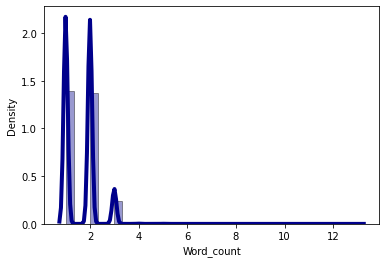

In [43]:
sns.distplot(df['Word_count'], hist= True, kde= True,
            bins= int(180/5), color= 'darkblue',
            hist_kws={'edgecolor': 'black'},
            kde_kws= {'linewidth': 4})
plt.show()

In [44]:
x = df['Review']
y = df['Rating']

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
word_vectorizer = TfidfVectorizer(sublinear_tf= True,
                                  strip_accents= 'unicode',
                                  analyzer= 'word',
                                  token_pattern= r'\w{1,}',
                                  stop_words= 'english',
                                  ngram_range=(1,3))

In [47]:
word_vectorizer.fit(x)
train_word_features = word_vectorizer.transform(x)

In [50]:
from scipy.sparse import hstack
char_vectorizer = TfidfVectorizer(sublinear_tf= True,
                                  strip_accents= 'unicode',
                                  analyzer= 'char',
                                  stop_words= 'english',
                                  ngram_range=(2,6),
                                  max_features= 50000)

char_vectorizer.fit(x)
train_char_features = char_vectorizer.transform(x)

train_features = hstack([train_char_features, train_word_features])

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:502: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


In [59]:
X_train, X_test, y_train, y_test = train_test_split(train_features, y, test_size= 0.3, random_state= 50)

In [62]:
rf = RandomForestClassifier(criterion= 'entropy',n_estimators= 100,
                            max_depth= 5, random_state= 50, n_jobs= -1)

pred1 = rf.fit(X_train, y_train).predict(X_test)

In [63]:
print('accuracy score : ', metrics.accuracy_score(pred1, y_test))
print(metrics.classification_report(pred1, y_test))
print(metrics.confusion_matrix(pred1, y_test))

accuracy score :  0.5569375345494748
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.56      0.72      7236

    accuracy                           0.56      7236
   macro avg       0.20      0.11      0.14      7236
weighted avg       1.00      0.56      0.72      7236

[[   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [ 602  248  674 1682 4030]]


In [64]:
lr = LogisticRegression(C= 2, n_jobs= 5, multi_class= 'ovr')

pred2 = lr.fit(X_train, y_train).predict(X_test)

In [65]:
print('accuracy score : ', metrics.accuracy_score(pred2, y_test))
print(metrics.classification_report(pred2, y_test))
print(metrics.confusion_matrix(pred2, y_test))

accuracy score :  0.5569375345494748
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.56      0.72      7235

    accuracy                           0.56      7236
   macro avg       0.20      0.11      0.14      7236
weighted avg       1.00      0.56      0.72      7236

[[   0    0    0    1    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [ 602  248  674 1681 4030]]


In [66]:
save_r = pickle.dumps(rf)